# Amazon Electronics datasets preprocessing

## `Importing libraries`

In [2]:
! pip install vaex
! pip install langdetect transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 56.9 MB/s eta 0:00:00

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from langdetect import detect
from transformers import MarianMTModel, MarianTokenizer
import vaex

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## `Loading datasets`

In [5]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Loading datasets
apple_df = pd.read_csv('/content/drive/MyDrive/Apple_products.csv')
pixel_df = pd.read_csv('/content/drive/MyDrive/pixel_products.csv')
samsung_df = pd.read_csv('/content/drive/MyDrive/Samsung_products.csv')

## `Dataset overview`

In [5]:
# Dataset sizes
print('Apple dataset size:', apple_df.shape)
print('Pixel dataset size:', pixel_df.shape)
print('Samsung dataset size:', samsung_df.shape)

Apple dataset size: (562, 10)
Pixel dataset size: (2015, 10)
Samsung dataset size: (33041, 10)


In [6]:
# Column names
print('Column names: ', apple_df.columns)

Column names:  Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase'],
      dtype='object')


In [7]:
apple_df.head(2)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Five Stars,perfect,[],B00NQHZ2RU,B00NQHZ2RU,AGYCCDOVYOOUDZOETUJN4U5KAGIA,1486140013000,0,True
1,5.0,LOVE this iPhone 6,So far extremely happy with the iPhone 6. Thi...,[],B00NQGOZCY,B00NQGOZCY,AHGSUXT56Q3XVYD6J3YBZMBOCXHA,1495430457000,2,True


In [8]:
# Null count in datasets
print('Apple dataset:\n',apple_df.isnull().sum())
print('Pixel dataset:\n',pixel_df.isnull().sum())
print('Samsung dataset:\n',samsung_df.isnull().sum())

Apple dataset:
 rating               0
title                1
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64
Pixel dataset:
 rating               0
title                1
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64
Samsung dataset:
 rating                0
title                16
text                 15
images                0
asin                  0
parent_asin           0
user_id               0
timestamp             0
helpful_vote          0
verified_purchase     0
dtype: int64


## `Data Preprocessing Pipeline`

In [9]:
# Extract only rating, title, text, parent_asin,timestamp and drop other columns
def drop_columns(df):
    df = df[['rating', 'title', 'text', 'parent_asin', 'timestamp']]
    return df

In [10]:
# Drop data records with null values for the text column
def drop_null_values(df):
    df = df.dropna(subset=['text'])
    return df

In [11]:
# Create pipeline
def pipeline(df):
    df = drop_columns(df)
    df = drop_null_values(df)
    return df

In [12]:
# Apply pipeline
apple_df = pipeline(apple_df)
pixel_df = pipeline(pixel_df)
samsung_df = pipeline(samsung_df)

## `Data visualization after the pipeline`

In [13]:
# Drop the rows with null for text in samsung_df
samsung_df.isnull().sum()

rating          0
title          12
text            0
parent_asin     0
timestamp       0
dtype: int64

In [14]:
apple_df.isnull().sum()

rating         0
title          1
text           0
parent_asin    0
timestamp      0
dtype: int64

In [15]:
pixel_df.isnull().sum()

rating         0
title          1
text           0
parent_asin    0
timestamp      0
dtype: int64

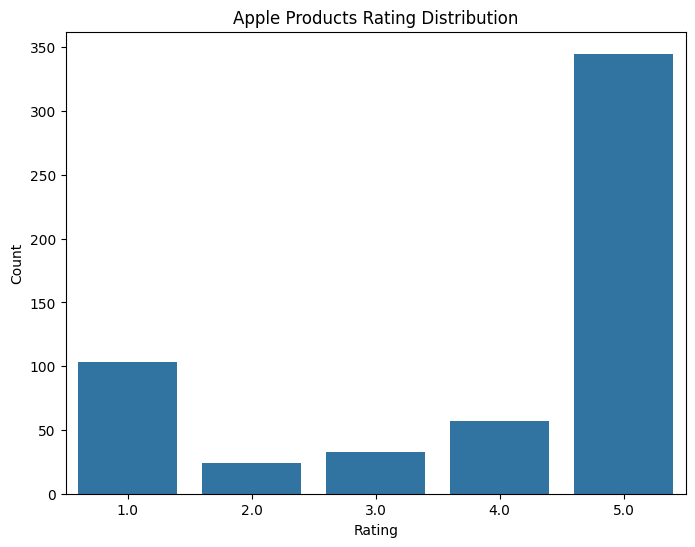

In [16]:
# Visualize the distribution of rating in apple_df
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=apple_df)
plt.title('Apple Products Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

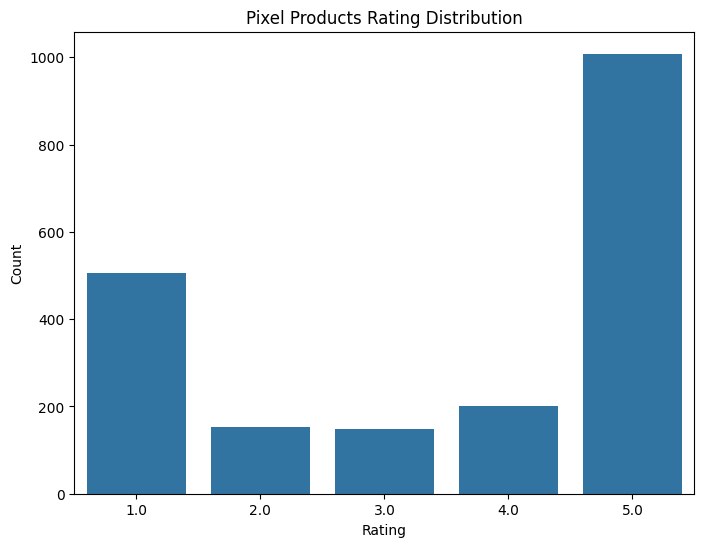

In [17]:
# Visualize the distribution of rating in pixel_df
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=pixel_df)
plt.title('Pixel Products Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

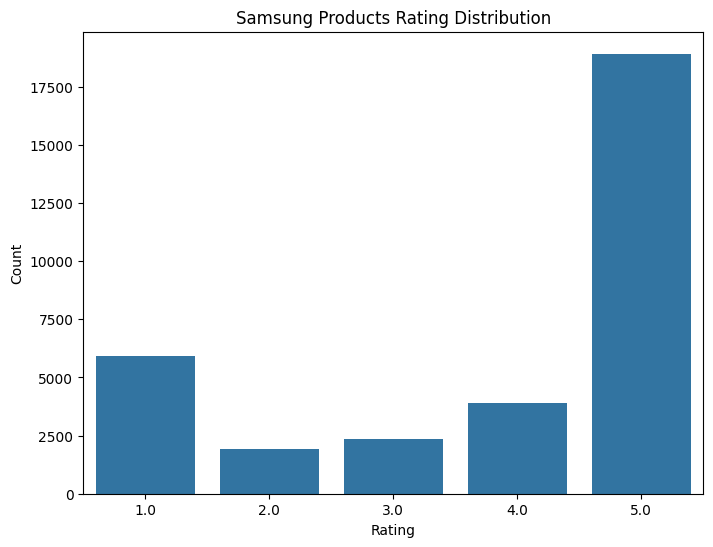

In [18]:
# Visualize the distribution of rating in samsung_df
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=samsung_df)
plt.title('Samsung Products Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [19]:
apple_df['text'].to_csv('drive/MyDrive/apple_reviews.csv', index=False)
pixel_df['text'].to_csv('drive/MyDrive/pixel_reviews.csv', index=False)
samsung_df['text'].to_csv('drive/MyDrive/samsung_reviews.csv', index=False)

## `Preprocessing text reviews`

In [6]:
# Loading review datasets
apple_review_df = pd.read_csv('/content/drive/MyDrive/apple_reviews.csv')
pixel_review_df = pd.read_csv('/content/drive/MyDrive/pixel_reviews.csv')
samsung_review_df = pd.read_csv('/content/drive/MyDrive/samsung_reviews.csv')

In [7]:
# Function to detect language
def detect_language(text):
    try:
        language = detect(text)
        return language
    except Exception as e:
        print(f"Error detecting language: {e}")
        return None

# Function to translate text to English
def translate_to_english(text, src_lang):
    model_name = f'Helsinki-NLP/opus-mt-{src_lang}-en'
    try:
        tokenizer = MarianTokenizer.from_pretrained(model_name)
        model = MarianMTModel.from_pretrained(model_name)
        translated = model.generate(**tokenizer(text, return_tensors="pt", padding=True))
        translated_text = tokenizer.batch_decode(translated, skip_special_tokens=True)[0]
        return translated_text
    except Exception as e:
        print(f"Error translating text: {e}")
        return None

# Function to lemmatize text
def lemmatize_text(text, stop_words, lemmatizer):
    text = text.lower()
    words = word_tokenize(text)
    negation_words = set(["not", "no", "never", "n't", "none"])
    negation_suffix = "_NEG"
    processed_words = []
    negation = False

    for word in words:
        if word in negation_words:
            negation = True
            processed_words.append(word)
            continue

        if negation:
            if word in string.punctuation:
                negation = False
            else:
                word = word + negation_suffix
                negation = False

        processed_words.append(word)

    processed_words = [word.translate(str.maketrans('', '', string.punctuation)) for word in processed_words if word not in stop_words]
    processed_words = [lemmatizer.lemmatize(word) for word in processed_words if word]

    return ' '.join(processed_words)

# Define the text processing pipeline as a function
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    lang = detect_language(text)
    if lang is None or lang != 'en':
        translated_text = translate_to_english(text, lang)
        if translated_text is not None:
            text = translated_text
        else:
            return None
    return lemmatize_text(text, stop_words, lemmatizer)

In [ ]:
# Load data using Vaex
df_vaex = vaex.open('/content/drive/MyDrive/apple_reviews.csv')

# Apply the preprocessing pipeline to each row using vaex's string operations
df_vaex['processed_text'] = df_vaex.text.apply(preprocess_text)

# Save the processed DataFrame
df_vaex.export('/content/drive/MyDrive/processed_apple_reviews.csv')

In [1]:
df_vaex_pixel = vaex.open('/content/drive/MyDrive/pixel_reviews.csv')

# Apply the preprocessing pipeline to each row using vaex's string operations
df_vaex_pixel['processed_text'] = df_vaex_pixel.text.apply(preprocess_text)

# Save the processed DataFrame
df_vaex_pixel.export('/content/drive/MyDrive/processed_pixel_reviews.csv')

NameError: name 'vaex' is not defined

In [ ]:
df_vaex_samsung = vaex.open('/content/drive/MyDrive/samsung_reviews.csv')

# Apply the preprocessing pipeline to each row using vaex's string operations
df_vaex_samsung['processed_text'] = df_vaex_samsung.text.apply(preprocess_text)

# Save the processed DataFrame
df_vaex_samsung.export('/content/drive/MyDrive/processed_samsung_reviews.csv')

Took 6mins to execute the above code

## `Analysing preprocessed text reviews`

In [ ]:
processed_apple_reviews = pd.read_csv('/content/drive/MyDrive/processed_apple_reviews.csv')
pd.set_option('display.max_colwidth', None)
processed_apple_reviews

,text,processed_text
0,perfect,perfect
1,"So far extremely happy with the iPhone 6. This works perfectly for what it was purchased for and nice to have the larger storage. Wasn't sure what iPhone to get, but very happy with this purchase and would highly recommend to anyone looking to get one. While it isn't the latest model, it still has many of the extra added features advertised by Apple. no regrets and happy to have this one",far extremely happy iphone 6 work perfectly purchased nice larger storage nt sureNEG iphone get happy purchase would highly recommend anyone looking get one nt theNEG latest model still many extra added feature advertised apple regretsNEG happy one
2,I would not recommend buying any electronics from this company; my phone came defected.,would recommendNEG buying electronics company phone came defected
3,Battery is trashed essentially making the phone unusable. Complete waste of money.,battery trashed essentially making phone unusable complete waste money
4,This is literally a brand new phone for a used phone price. I could not find a single scratch on this phone. I am so happy with this purchase. Saved a ton of money too.,literally brand new phone used phone price could findNEG single scratch phone happy purchase saved ton money
...,...,...
557,Phone was delivered ahead of schedule in a nice box with everything mentioned in the description. It was somewhat dirty but it only took about 10-15 minutes to clean it up. No major scratches or wear. Very happy with it.,phone delivered ahead schedule nice box everything mentioned description somewhat dirty took 1015 minute clean majorNEG scratch wear happy
558,The camera is very shaky when trying to take a picture or video unless in slow motion. The data does not work though I can receive and send text messages and phone calls.,camera shaky trying take picture video unless slow motion data workNEG though receive send text message phone call
559,I bought this an a month after I bought it it otally doesnt work,bought month bought otally doesnt work
560,Product worked as expected,product worked expected


In [ ]:
# 84th record
processed_apple_reviews.iloc[232]

text              No le funcionaban las camaras
processed_text                camera nt workNEG
Name: 232, dtype: object

In [ ]:
processed_apple_reviews.isnull().sum()

text               0
processed_text    12
dtype: int64

In [ ]:
# Drop the rows with null values for the processed_text
processed_apple_reviews = processed_apple_reviews.dropna(subset=['processed_text'])
processed_apple_reviews.isnull().sum()

text              0
processed_text    0
dtype: int64

In [ ]:
# Save the processed dataset
processed_apple_reviews.to_csv('drive/MyDrive/processed_n_cleaned_apple_reviews.csv', index=False)

## `Building Models`

### `Test01 - K-means clustering`

In [ ]:
# Load dataset
processed_reviews = pd.read_csv('/content/drive/MyDrive/processed_n_cleaned_apple_reviews.csv')

In [ ]:
processed_reviews.head()

,text,processed_text
0,perfect,perfect
1,"So far extremely happy with the iPhone 6. This works perfectly for what it was purchased for and nice to have the larger storage. Wasn't sure what iPhone to get, but very happy with this purchase and would highly recommend to anyone looking to get one. While it isn't the latest model, it still has many of the extra added features advertised by Apple. no regrets and happy to have this one",far extremely happy iphone 6 work perfectly purchased nice larger storage nt sureNEG iphone get happy purchase would highly recommend anyone looking get one nt theNEG latest model still many extra added feature advertised apple regretsNEG happy one
2,I would not recommend buying any electronics from this company; my phone came defected.,would recommendNEG buying electronics company phone came defected
3,Battery is trashed essentially making the phone unusable. Complete waste of money.,battery trashed essentially making phone unusable complete waste money
4,This is literally a brand new phone for a used phone price. I could not find a single scratch on this phone. I am so happy with this purchase. Saved a ton of money too.,literally brand new phone used phone price could findNEG single scratch phone happy purchase saved ton money


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans


# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
X_tfidf = tfidf_vectorizer.fit_transform(processed_reviews['processed_text'])

# Initialize K-means clustering
k = 3  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_tfidf)

# Analyze clusters
processed_reviews['cluster_label'] = kmeans.labels_

# Print clusters
for cluster_id in range(k):
    cluster_samples = processed_reviews[processed_reviews['cluster_label'] == cluster_id]['processed_text'].tolist()
    print(f"Cluster {cluster_id}:")
    for sample in cluster_samples[:5]:  # Print first 5 samples per cluster
        print(f" - {sample}")
    print()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0:
 - like red phone used great condition bit scratch phone work
 - great phone best price amount memory
 - work great
 - work grareat
 - great

Cluster 1:
 - far extremely happy iphone 6 work perfectly purchased nice larger storage nt sureNEG iphone get happy purchase would highly recommend anyone looking get one nt theNEG latest model still many extra added feature advertised apple regretsNEG happy one
 - would recommendNEG buying electronics company phone came defected
 - battery trashed essentially making phone unusable complete waste money
 - daughter love phone problemsNEG
 - work well

Cluster 2:
 - perfect
 - literally brand new phone used phone price could findNEG single scratch phone happy purchase saved ton money
 - came mint condition 100 battery life scratchesNEG whatsoever brand new would say happy costumer
 - phone perfect like new far problemsNEG love size phone
 - looked like brand new phone sent back camera ’ work shook bad



In [ ]:
processed_reviews.head()

,text,processed_text,cluster_label
0,perfect,perfect,2
1,"So far extremely happy with the iPhone 6. This works perfectly for what it was purchased for and nice to have the larger storage. Wasn't sure what iPhone to get, but very happy with this purchase and would highly recommend to anyone looking to get one. While it isn't the latest model, it still has many of the extra added features advertised by Apple. no regrets and happy to have this one",far extremely happy iphone 6 work perfectly purchased nice larger storage nt sureNEG iphone get happy purchase would highly recommend anyone looking get one nt theNEG latest model still many extra added feature advertised apple regretsNEG happy one,1
2,I would not recommend buying any electronics from this company; my phone came defected.,would recommendNEG buying electronics company phone came defected,1
3,Battery is trashed essentially making the phone unusable. Complete waste of money.,battery trashed essentially making phone unusable complete waste money,1
4,This is literally a brand new phone for a used phone price. I could not find a single scratch on this phone. I am so happy with this purchase. Saved a ton of money too.,literally brand new phone used phone price could findNEG single scratch phone happy purchase saved ton money,2


K-means clustering doesn't work well

### `Test02 - Hierarchical Clustering`

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering
clustering_model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  # Adjust n_clusters as needed
labels = clustering_model.fit_predict(X_tfidf.toarray())

# Add the cluster labels to the DataFrame
processed_reviews['hierarchical_cluster'] = labels


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [ ]:
processed_reviews.head()

,text,processed_text,cluster_label,hierarchical_cluster
0,perfect,perfect,2,2
1,"So far extremely happy with the iPhone 6. This works perfectly for what it was purchased for and nice to have the larger storage. Wasn't sure what iPhone to get, but very happy with this purchase and would highly recommend to anyone looking to get one. While it isn't the latest model, it still has many of the extra added features advertised by Apple. no regrets and happy to have this one",far extremely happy iphone 6 work perfectly purchased nice larger storage nt sureNEG iphone get happy purchase would highly recommend anyone looking get one nt theNEG latest model still many extra added feature advertised apple regretsNEG happy one,1,0
2,I would not recommend buying any electronics from this company; my phone came defected.,would recommendNEG buying electronics company phone came defected,1,0
3,Battery is trashed essentially making the phone unusable. Complete waste of money.,battery trashed essentially making phone unusable complete waste money,1,0
4,This is literally a brand new phone for a used phone price. I could not find a single scratch on this phone. I am so happy with this purchase. Saved a ton of money too.,literally brand new phone used phone price could findNEG single scratch phone happy purchase saved ton money,2,0


Hierarchical clustering doesn't work well

### `Test03 - DBSCAN (Density-Based Spatial Clustering of Applications with Noise)`

In [ ]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed
labels = dbscan.fit_predict(X_tfidf)

# Add cluster labels to the DataFrame
processed_reviews['dbscan_cluster'] = labels


In [ ]:
processed_reviews.head()

,text,processed_text,cluster_label,hierarchical_cluster,dbscan_cluster
0,perfect,perfect,2,2,0
1,"So far extremely happy with the iPhone 6. This works perfectly for what it was purchased for and nice to have the larger storage. Wasn't sure what iPhone to get, but very happy with this purchase and would highly recommend to anyone looking to get one. While it isn't the latest model, it still has many of the extra added features advertised by Apple. no regrets and happy to have this one",far extremely happy iphone 6 work perfectly purchased nice larger storage nt sureNEG iphone get happy purchase would highly recommend anyone looking get one nt theNEG latest model still many extra added feature advertised apple regretsNEG happy one,1,0,-1
2,I would not recommend buying any electronics from this company; my phone came defected.,would recommendNEG buying electronics company phone came defected,1,0,-1
3,Battery is trashed essentially making the phone unusable. Complete waste of money.,battery trashed essentially making phone unusable complete waste money,1,0,-1
4,This is literally a brand new phone for a used phone price. I could not find a single scratch on this phone. I am so happy with this purchase. Saved a ton of money too.,literally brand new phone used phone price could findNEG single scratch phone happy purchase saved ton money,2,0,-1


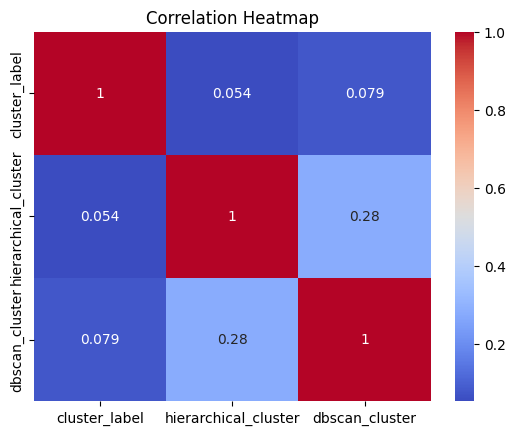

In [ ]:
# correlation heat-map of cluster values
sns.heatmap(processed_reviews[['cluster_label', 'hierarchical_cluster', 'dbscan_cluster']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

No observable correlation between the cluster values obtained from the above methods

## `Pretrained Sentiment Analysis Models`

### `Vader Model`

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# Sentiment Analysis using VADER
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()
sentiments1 = [sid.polarity_scores(text) for text in processed_reviews['text']]
sentiments2 = [sid.polarity_scores(text) for text in processed_reviews['processed_text']]

In [ ]:
processed_reviews['vader_score1'] = sentiments1

In [ ]:
processed_reviews['vader_score2'] = sentiments2

In [ ]:
processed_reviews.drop('vader_score', axis=1, inplace=True)
processed_reviews.drop('vader2', axis=1, inplace=True)

In [ ]:
processed_reviews.head()

,text,processed_text,cluster_label,hierarchical_cluster,dbscan_cluster,vader_score1,vader_score2
0,perfect,perfect,2,2,0,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5719}","{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5719}"
1,"So far extremely happy with the iPhone 6. This works perfectly for what it was purchased for and nice to have the larger storage. Wasn't sure what iPhone to get, but very happy with this purchase and would highly recommend to anyone looking to get one. While it isn't the latest model, it still has many of the extra added features advertised by Apple. no regrets and happy to have this one",far extremely happy iphone 6 work perfectly purchased nice larger storage nt sureNEG iphone get happy purchase would highly recommend anyone looking get one nt theNEG latest model still many extra added feature advertised apple regretsNEG happy one,1,0,-1,"{'neg': 0.081, 'neu': 0.677, 'pos': 0.243, 'compound': 0.9521}","{'neg': 0.0, 'neu': 0.587, 'pos': 0.413, 'compound': 0.9711}"
2,I would not recommend buying any electronics from this company; my phone came defected.,would recommendNEG buying electronics company phone came defected,1,0,-1,"{'neg': 0.304, 'neu': 0.696, 'pos': 0.0, 'compound': -0.5873}","{'neg': 0.278, 'neu': 0.722, 'pos': 0.0, 'compound': -0.4019}"
3,Battery is trashed essentially making the phone unusable. Complete waste of money.,battery trashed essentially making phone unusable complete waste money,1,0,-1,"{'neg': 0.203, 'neu': 0.797, 'pos': 0.0, 'compound': -0.4215}","{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'compound': -0.4215}"
4,This is literally a brand new phone for a used phone price. I could not find a single scratch on this phone. I am so happy with this purchase. Saved a ton of money too.,literally brand new phone used phone price could findNEG single scratch phone happy purchase saved ton money,2,0,-1,"{'neg': 0.0, 'neu': 0.782, 'pos': 0.218, 'compound': 0.8196}","{'neg': 0.0, 'neu': 0.698, 'pos': 0.302, 'compound': 0.7579}"


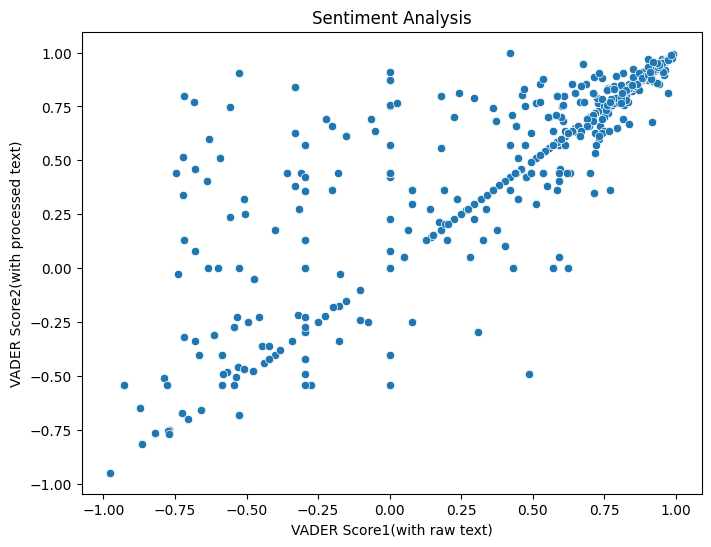

In [ ]:
# visualize the relation ship of compound scores of vader_score and vader2
vader_compound1 = [sentiment['compound'] for sentiment in sentiments1]
vader_compound2 = [sentiment['compound'] for sentiment in sentiments2]

df = pd.DataFrame({'vader_compound1': vader_compound1, 'vader_compound2': vader_compound2})

plt.figure(figsize=(8, 6))
sns.scatterplot(x='vader_compound1', y='vader_compound2',data=df)
plt.title('Sentiment Analysis')
plt.xlabel('VADER Score1(with raw text)')
plt.ylabel('VADER Score2(with processed text)')
plt.show()

In [ ]:
df.head()

,vader_compound1,vader_compound2
0,0.5719,0.5719
1,0.9521,0.9711
2,-0.5873,-0.4019
3,-0.4215,-0.4215
4,0.8196,0.7579


In [ ]:
processed_reviews.to_csv('drive/MyDrive/apple_model_results.csv', index=False)

## `Topic Modelling`

### `Model01 - LDA`

In [ ]:
processed_reviews.head()

,text,processed_text,cluster_label,hierarchical_cluster,dbscan_cluster,vader_score1,vader_score2
0,perfect,perfect,2,2,0,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5719}","{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5719}"
1,"So far extremely happy with the iPhone 6. This works perfectly for what it was purchased for and nice to have the larger storage. Wasn't sure what iPhone to get, but very happy with this purchase and would highly recommend to anyone looking to get one. While it isn't the latest model, it still has many of the extra added features advertised by Apple. no regrets and happy to have this one",far extremely happy iphone 6 work perfectly purchased nice larger storage nt sureNEG iphone get happy purchase would highly recommend anyone looking get one nt theNEG latest model still many extra added feature advertised apple regretsNEG happy one,1,0,-1,"{'neg': 0.081, 'neu': 0.677, 'pos': 0.243, 'compound': 0.9521}","{'neg': 0.0, 'neu': 0.587, 'pos': 0.413, 'compound': 0.9711}"
2,I would not recommend buying any electronics from this company; my phone came defected.,would recommendNEG buying electronics company phone came defected,1,0,-1,"{'neg': 0.304, 'neu': 0.696, 'pos': 0.0, 'compound': -0.5873}","{'neg': 0.278, 'neu': 0.722, 'pos': 0.0, 'compound': -0.4019}"
3,Battery is trashed essentially making the phone unusable. Complete waste of money.,battery trashed essentially making phone unusable complete waste money,1,0,-1,"{'neg': 0.203, 'neu': 0.797, 'pos': 0.0, 'compound': -0.4215}","{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'compound': -0.4215}"
4,This is literally a brand new phone for a used phone price. I could not find a single scratch on this phone. I am so happy with this purchase. Saved a ton of money too.,literally brand new phone used phone price could findNEG single scratch phone happy purchase saved ton money,2,0,-1,"{'neg': 0.0, 'neu': 0.782, 'pos': 0.218, 'compound': 0.8196}","{'neg': 0.0, 'neu': 0.698, 'pos': 0.302, 'compound': 0.7579}"


In [ ]:
# New dataframe with processed_text, sentiment2
selected = processed_reviews[['processed_text', 'vader_score2']]

In [ ]:
# access the element compound in vader_score2 dictionary
selected['vader_score2'] = [sentiment['compound'] for sentiment in sentiments2]

<ipython-input-139-262bf6e3f8f4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected['vader_score2'] = [sentiment['compound'] for sentiment in sentiments2]


In [ ]:
selected

,processed_text,vader_score2
0,perfect,0.5719
1,far extremely happy iphone 6 work perfectly purchased nice larger storage nt sureNEG iphone get happy purchase would highly recommend anyone looking get one nt theNEG latest model still many extra added feature advertised apple regretsNEG happy one,0.9711
2,would recommendNEG buying electronics company phone came defected,-0.4019
3,battery trashed essentially making phone unusable complete waste money,-0.4215
4,literally brand new phone used phone price could findNEG single scratch phone happy purchase saved ton money,0.7579
...,...,...
545,phone delivered ahead schedule nice box everything mentioned description somewhat dirty took 1015 minute clean majorNEG scratch wear happy,0.7645
546,camera shaky trying take picture video unless slow motion data workNEG though receive send text message phone call,-0.2263
547,bought month bought otally doesnt work,0.0000
548,product worked expected,0.0000


In [ ]:
# choose records with vader_score2 <0
selected = selected[selected['vader_score2'] < 0]

In [ ]:
selected

,processed_text,vader_score2
2,would recommendNEG buying electronics company phone came defected,-0.4019
3,battery trashed essentially making phone unusable complete waste money,-0.4215
7,iphone 8 goodNEG box screen re horrible volume goodNEG returning,-0.5423
14,received wrong item,-0.4767
19,iphone s screen delayed reaction continues scrolling place call touchingNEG place call mute frustrating huge disappointment looking new iphone,-0.7003
...,...,...
531,charger came barely gave juice basically useless phone came quality condition sometimes right side screen ’ respond ’ turn screen sometimes multiple time start responding everything else fine,-0.2500
535,refurbished iphone 12 pro came without plug without startup guide without sim tool thing listed would box description bought might cool replacing iphone ifNEG ve never ownedNEG kind iphone got dead iphone cord need phone m concerned phone may lacking area paid 72900 gotten promised,-0.5067
540,sold new aftermarket screen poorly installed loose screw home button became nonfunctional within 5 month ear bud appleNEG obviously bait switch,-0.4019
544,phone came work well however refurbished phone country u camera shutter noise beNEG muted incredibly annoying,-0.2247


In [ ]:
# Convert Text Data to Document-Term Matrix
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(selected['processed_text'])

In [ ]:
# Apply LDA
from sklearn.decomposition import LatentDirichletAllocation

# Initialize LDA
lda = LatentDirichletAllocation(n_components=10, random_state=42)  # Adjust n_components (number of topics) as needed
lda.fit(dtm)

LatentDirichletAllocation(random_state=42)

In [ ]:
# Get the feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Function to display the top words in each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display the top words in each topic
display_topics(lda, feature_names, 10)


Topic 1:
phone problem apple hour got day iphone new old service
Topic 2:
phone amazon screen seller battery camera waste hold buyneg renewed
Topic 3:
bad nt screen time io returned went button difficult home
Topic 4:
br say iphone phone received new locked really battery unlocked
Topic 5:
gb br horrible product turn sound people color hear make
Topic 6:
phone nt came evenneg buyneg bad money trying workneg turn
Topic 7:
wrong service battery money workneg horrible waste receive making item
Topic 8:
br phone seller new nt bought work problem amazon return
Topic 9:
phone iphone screen right work got fixed refund nt apple
Topic 10:
iphone buy place lock knowneg work nt company started workneg


In [ ]:
# Output Sentiment Scores
for review, sentiment in zip(preprocess_text['processed_review'], sentiments):
    print(f"Review: {review}\nSentiment: {sentiment}\n")

Review: perfect
Sentiment: {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5719}

Review: far extremely happy iphone 6 work perfectly purchased nice larger storage nt sureNEG iphone get happy purchase would highly recommend anyone looking get one nt theNEG latest model still many extra added feature advertised apple regretsNEG happy one
Sentiment: {'neg': 0.0, 'neu': 0.587, 'pos': 0.413, 'compound': 0.9711}

Review: would recommendNEG buying electronics company phone came defected
Sentiment: {'neg': 0.278, 'neu': 0.722, 'pos': 0.0, 'compound': -0.4019}

Review: battery trashed essentially making phone unusable complete waste money
Sentiment: {'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'compound': -0.4215}

Review: literally brand new phone used phone price could findNEG single scratch phone happy purchase saved ton money
Sentiment: {'neg': 0.0, 'neu': 0.698, 'pos': 0.302, 'compound': 0.7579}

Review: daughter love phone problemsNEG
Sentiment: {'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'c

In [ ]:
# append the compund score as a new column named score to the preprocess_text
preprocess_text['score'] = [sentiment['compound'] for sentiment in sentiments]

In [ ]:
preprocess_text.head()

,text,processed_review,cluster_label,score
0,perfect,perfect,1,0.5719
1,"So far extremely happy with the iPhone 6. This works perfectly for what it was purchased for and nice to have the larger storage. Wasn't sure what iPhone to get, but very happy with this purchase and would highly recommend to anyone looking to get one. While it isn't the latest model, it still has many of the extra added features advertised by Apple. no regrets and happy to have this one",far extremely happy iphone 6 work perfectly purchased nice larger storage nt sureNEG iphone get happy purchase would highly recommend anyone looking get one nt theNEG latest model still many extra added feature advertised apple regretsNEG happy one,1,0.9711
2,I would not recommend buying any electronics from this company; my phone came defected.,would recommendNEG buying electronics company phone came defected,1,-0.4019
3,Battery is trashed essentially making the phone unusable. Complete waste of money.,battery trashed essentially making phone unusable complete waste money,1,-0.4215
4,This is literally a brand new phone for a used phone price. I could not find a single scratch on this phone. I am so happy with this purchase. Saved a ton of money too.,literally brand new phone used phone price could findNEG single scratch phone happy purchase saved ton money,0,0.7579


In [ ]:
preprocess_text['score'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 562 entries, 0 to 561
Series name: score
Non-Null Count  Dtype  
--------------  -----  
562 non-null    float64
dtypes: float64(1)
memory usage: 4.5 KB


In [ ]:
# max and min values of score
print(preprocess_text['score'].max())
print(preprocess_text['score'].min())

0.9923
-0.9498


In [ ]:
# transform the score in -1 to +1 range to 0 to 5 range

#new column with null values
preprocess_text['sentiment_score'] = np.nan

#transform the score in -1 to +1 range to 0 to 5 range
for i in range(len(preprocess_text['score'])):
  if preprocess_text['score'][i] > 0.5:
    preprocess_text['sentiment_score'][i] = 'positive'
  elif preprocess_text['score'][i] < -0.5:
    preprocess_text['sentiment_score'][i] = 'negative'
  else:
    preprocess_text['sentiment_score'][i] = 'neutral'

<ipython-input-80-2336c7666fae>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprocess_text['sentiment_score'][i] = 'positive'


In [ ]:
preprocess_text.head()

,text,processed_review,cluster_label,score,sentiment_score
0,perfect,perfect,1,0.5719,positive
1,"So far extremely happy with the iPhone 6. This works perfectly for what it was purchased for and nice to have the larger storage. Wasn't sure what iPhone to get, but very happy with this purchase and would highly recommend to anyone looking to get one. While it isn't the latest model, it still has many of the extra added features advertised by Apple. no regrets and happy to have this one",far extremely happy iphone 6 work perfectly purchased nice larger storage nt sureNEG iphone get happy purchase would highly recommend anyone looking get one nt theNEG latest model still many extra added feature advertised apple regretsNEG happy one,1,0.9711,positive
2,I would not recommend buying any electronics from this company; my phone came defected.,would recommendNEG buying electronics company phone came defected,1,-0.4019,neutral
3,Battery is trashed essentially making the phone unusable. Complete waste of money.,battery trashed essentially making phone unusable complete waste money,1,-0.4215,neutral
4,This is literally a brand new phone for a used phone price. I could not find a single scratch on this phone. I am so happy with this purchase. Saved a ton of money too.,literally brand new phone used phone price could findNEG single scratch phone happy purchase saved ton money,0,0.7579,positive


In [ ]:
preprocess_text.drop('cluster_label', axis=1, inplace=True)

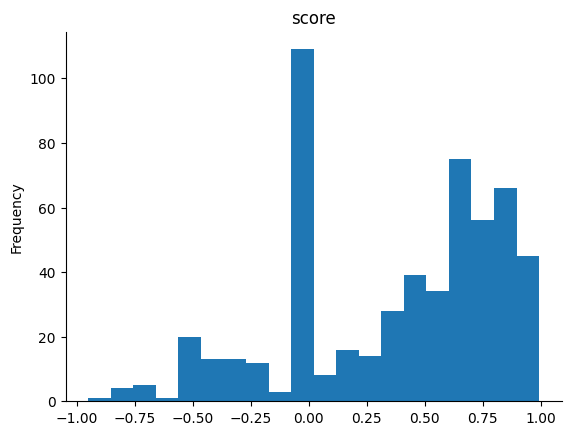

In [ ]:
# @title score

from matplotlib import pyplot as plt
preprocess_text['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
preprocess_text.to_csv('drive/MyDrive/apple_data_analysed.csv', index=False)

In [ ]:
apple_processed = pd.read_csv('drive/MyDrive/apple_data_analysed.csv')

In [ ]:
apple_processed.head()

,text,processed_review,score,sentiment_score
0,perfect,perfect,0.5719,positive
1,So far extremely happy with the iPhone 6. Thi...,far extremely happy iphone 6 work perfectly pu...,0.9711,positive
2,I would not recommend buying any electronics f...,would recommendNEG buying electronics company ...,-0.4019,neutral
3,Battery is trashed essentially making the phon...,battery trashed essentially making phone unusa...,-0.4215,neutral
4,This is literally a brand new phone for a used...,literally brand new phone used phone price cou...,0.7579,positive


In [ ]:
apple_df

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Five Stars,perfect,[],B00NQHZ2RU,B00NQHZ2RU,AGYCCDOVYOOUDZOETUJN4U5KAGIA,1486140013000,0,True
1,5.0,LOVE this iPhone 6,So far extremely happy with the iPhone 6. Thi...,[],B00NQGOZCY,B00NQGOZCY,AHGSUXT56Q3XVYD6J3YBZMBOCXHA,1495430457000,2,True
2,1.0,Malfunction a lot,I would not recommend buying any electronics f...,[],B07234GKN5,B07234GKN5,AFV4KKH356TLSZEHI3UBHN4SYSJQ,1582741702541,2,True
3,1.0,Battery is done for.,Battery is trashed essentially making the phon...,[],B07CQNF813,B07CQNF813,AFTPWGVZUDMJE5UUADHHZBQK4AIQ,1581536080691,0,True
4,5.0,Brand new phone,This is literally a brand new phone for a used...,[],B09JFN8K6T,B09JFN8K6T,AFBJCNQY5YUKIKOZT4OB2EQ7JWXA,1671675512431,3,True
...,...,...,...,...,...,...,...,...,...,...
557,5.0,So far so good!,Phone was delivered ahead of schedule in a nic...,[],B07234GKN5,B07234GKN5,AG5PUKOPK44RN3AOBIKHZKBWF37Q,1547241048498,3,True
558,2.0,I need a refund or new phone please contact me!!!,The camera is very shaky when trying to take a...,[],B07234GKN5,B07234GKN5,AGXRAITRVQW7QS7EKOVLWK3LXNIA,1572410517164,2,True
559,1.0,It doesnt work!,I bought this an a month after I bought it it ...,[],B07234GKN5,B07234GKN5,AFCVQHOKT3O54IOHSS24XEFQHXMA,1572935042786,3,True
560,5.0,Good supplier,Product worked as expected,[],B07759SBP7,B07759SBP7,AH6OJZQU5RIK55HIDN2WUHNY6ZCA,1557508195982,0,True


In [ ]:
# get the rating from the apple_df and visualize the correlation with the sentiment_score
apple_df['rating'].corr(apple_processed['score'])

0.5867658515796997

In [ ]:
apple_processed['rating'] = np.nan
for i in range (apple_df.shape[0]):
  if apple_df['rating'][i] >= 4:
    apple_processed['rating'][i] = 'positive'
  elif apple_df['rating'][i]==3:
    apple_processed['rating'][i] = 'neutral'
  else:
    apple_processed['rating'][i] = 'negative'

<ipython-input-10-9d7f9a852160>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_processed['rating'][i] = 'positive'


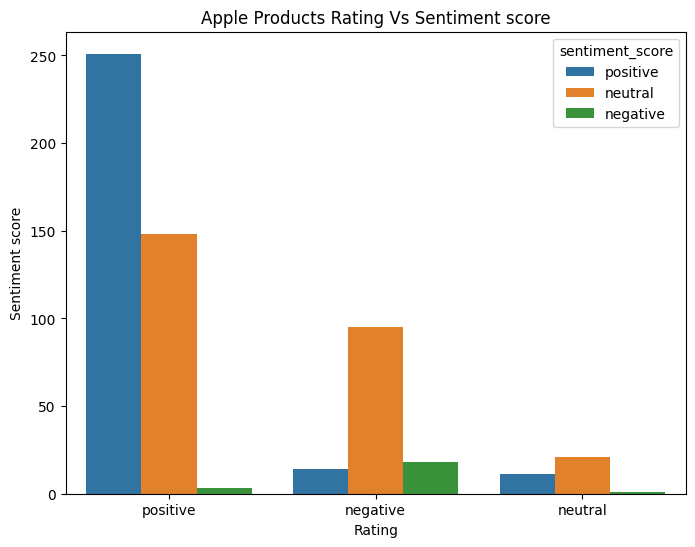

In [ ]:
# visualize the distribution between rating and score
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', hue='sentiment_score', data=apple_processed)
plt.title('Apple Products Rating Vs Sentiment score')
plt.xlabel('Rating')
plt.ylabel('Sentiment score')
plt.show()